In [1]:
import numpy as np
import pylab as plt
from matplotlib import pyplot as plt
from tqdm import tqdm
%matplotlib inline
%config InlineBackend.figure_format='retina'
plt.rcParams['figure.figsize'] = [7,5]
import scipy
from scipy.stats import uniform

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, RationalQuadratic, ConstantKernel

from astropy import units as u
from astropy.cosmology import LambdaCDM
from astroML.datasets import generate_mu_z

import warnings; warnings.simplefilter('ignore')
import corner
import dynesty
from dynesty import plotting as dyplot
from dynesty import utils as dyfunc
import time

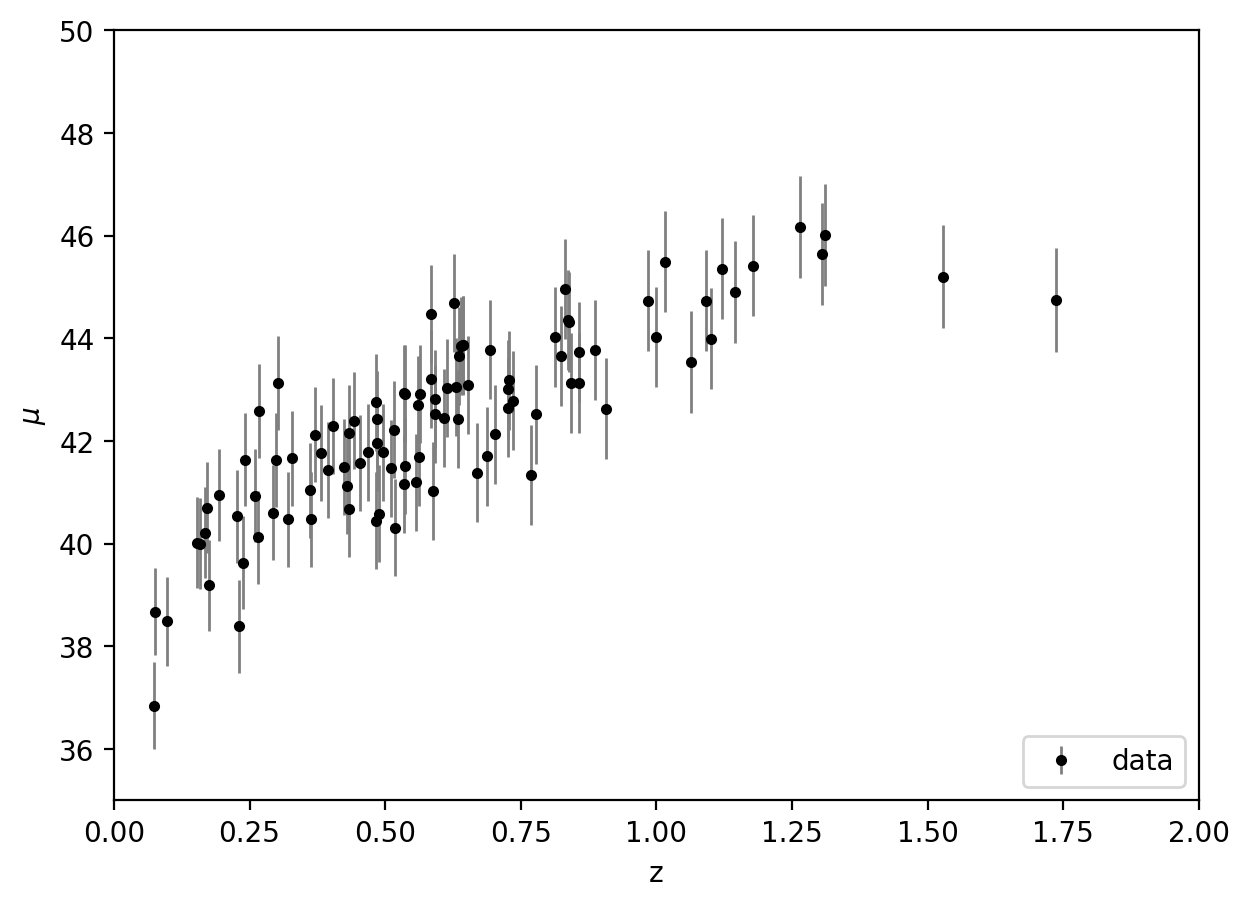

In [2]:
z_sample, mu_sample, dmu = generate_mu_z(100, random_state=1234)

plt.errorbar(z_sample, mu_sample, dmu, fmt='.k', ecolor='gray', lw=1,label='data')
plt.xlabel("z")
plt.ylabel("$\mu$")
plt.legend(loc='lower right')
plt.xlim(0,2)
plt.ylim(35,50)

x=z_sample.copy()[:,np.newaxis]
y=mu_sample.copy()[:,np.newaxis]
dy=dmu.copy()

## GPR

I try with both the Radial basis function kernel (parameters: the length of the 'wiggles' in your function, ℓ) and the Rational quadratic kernel (parameters: lengthscale ℓ and the relative weighting of large-scale and small-scale variations, α).They are multiplied by a constant kernel (parameter: constant value) that scales their magnitude.

Radial basis function kernel :

Best-fit kernel:  30.7**2 * RBF(length_scale=3.9)


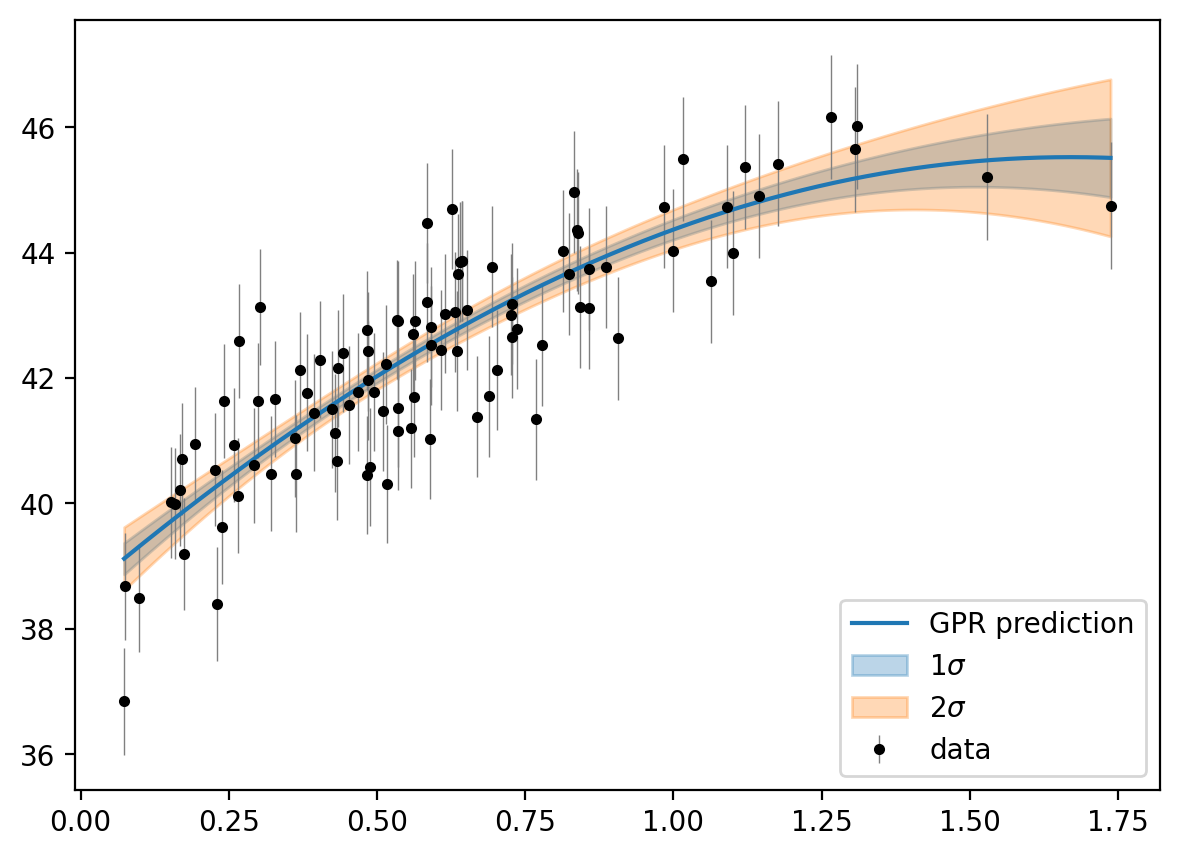

Rational quadratic kernel :

Best-fit kernel:  38.5**2 * RationalQuadratic(alpha=0.0218, length_scale=5.84)


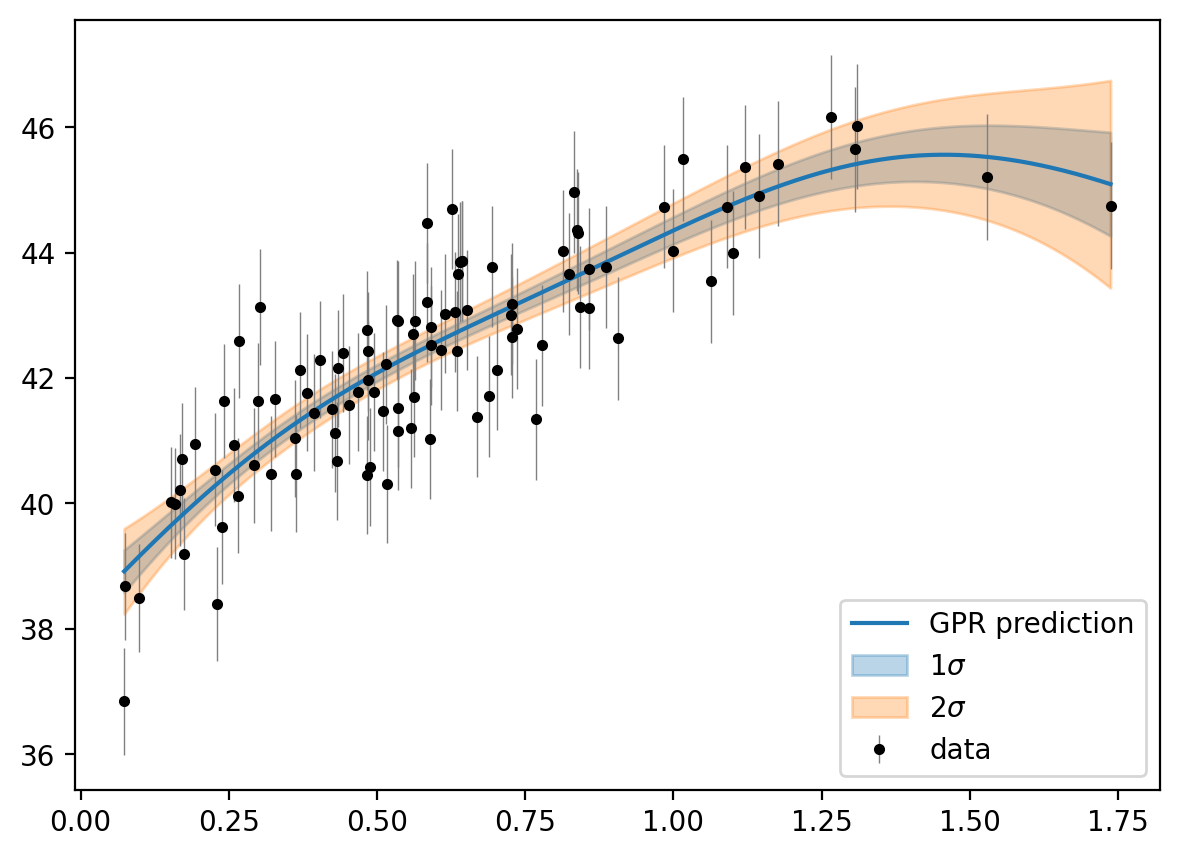

In [3]:
kernel = ConstantKernel(1,(1e-5,1e5))*RBF(1, (0.1,10))
kernel2 = ConstantKernel(1,(1e-5,1e5))*RationalQuadratic(1, 1, (0.1,10),(1e-5,1e5))

x_grid=np.linspace(min(x[:,0]),max(x[:,0]),1000)[:, np.newaxis]

for kernel,name in zip([kernel, kernel2],['Radial basis function kernel','Rational quadratic kernel']):
    print(name,':')
    gp = GaussianProcessRegressor(kernel=kernel,alpha=(dy**2), random_state=1)
    gp.fit(x,y)
    y_pred, dy_pred = gp.predict(x_grid, return_std=True)
    plt.errorbar(z_sample, mu_sample, dmu, fmt='.k', ecolor='gray', lw=0.5,label='data')
    plt.plot(x_grid, y_pred, '-', color='C0', label='GPR prediction')
    plt.fill_between(x_grid[:,0], y_pred - 1 * dy_pred, y_pred + 1 * dy_pred, color='C0', alpha=0.3, label='1$\sigma$')
    plt.fill_between(x_grid[:,0], y_pred - 2 * dy_pred, y_pred + 2 * dy_pred, color='C1', alpha=0.3, label='2$\sigma$')
    plt.legend(loc="lower right",fontsize=10) 
    print('\nBest-fit kernel: ', gp.kernel_)
    plt.show()

But these results depend on the choice of the hyperparameters, so I do a CV test where I vary the hyperparameters for the Rational quadratic kernel

Best-fit kernel:  30.7**2 * RationalQuadratic(alpha=1e+04, length_scale=3.9)


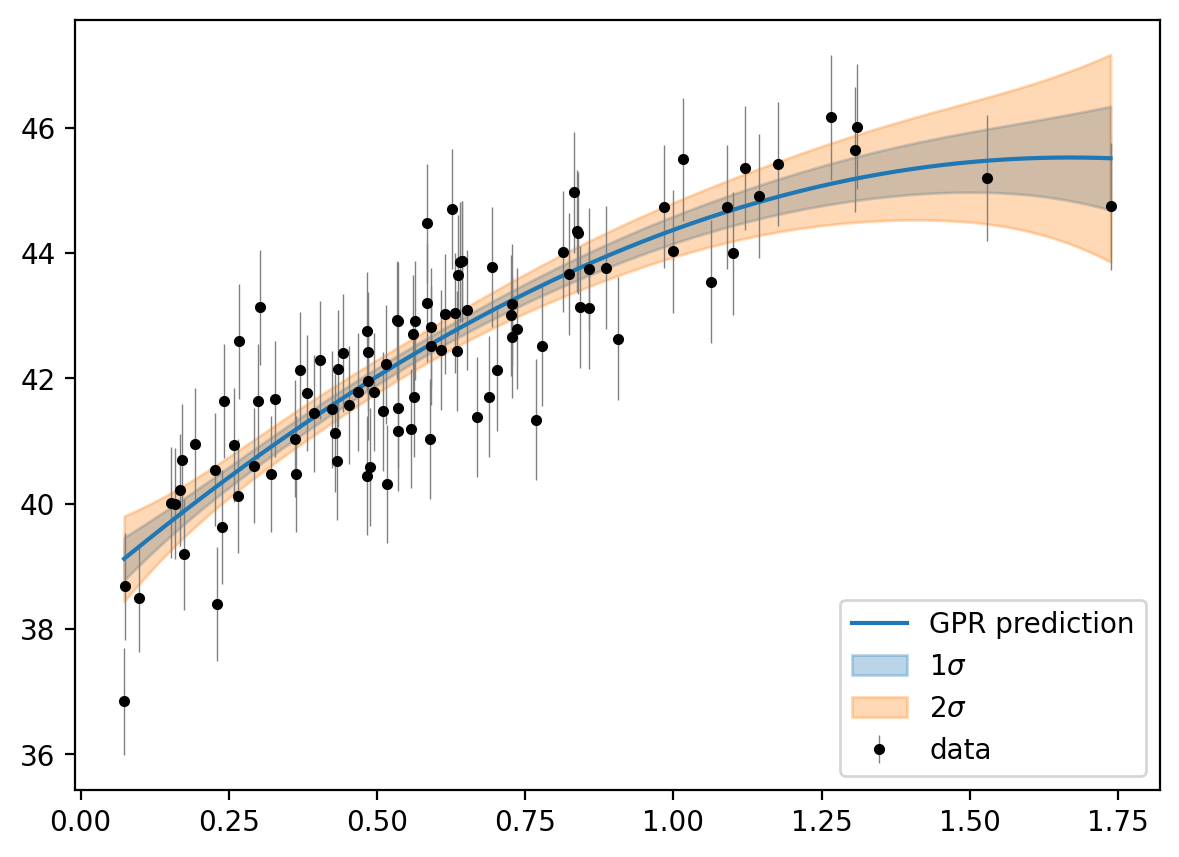

In [4]:
alpha = np.geomspace(1e-3,1e3,5)
cost = np.geomspace(1e-5,1e5,5)
lenght = np.linspace(1e-1,1e1,5)
par = np.array(np.meshgrid(cost, lenght,alpha)).T.reshape(-1,3)
ind = np.arange(len(x),dtype=int)

np.random.seed(0)
cv_err = np.zeros(len(par))
np.random.shuffle(ind)
train = np.split(ind,4)

for i in range(len(par)):
    cv_dist=np.array([])
    bounds=np.array([])
    for cv in train:
    
        x_cv=x[cv]
        y_cv=y[cv]
        dy_cv=dy[cv]

        x_train = np.delete(x,(cv),axis=0)
        y_train = np.delete(y,(cv),axis=0)
        dy_train = np.delete(dy,(cv),axis=0)
        bounds = np.array([par[i,:3]*1e-3,par[i,:3]*1e3])
        kernel = ConstantKernel(par[i,0],bounds[:,0])*RationalQuadratic(par[i,1],par[i,2],bounds[:,1],bounds[:,2])
        
        gp = GaussianProcessRegressor(kernel=kernel,alpha=(dy_train**2), random_state=1)
        gp.fit(x_train, y_train)
        dist = np.sum((gp.predict(x_cv) - y_cv[:,0])**2)
        cv_dist = np.append(cv_dist,dist)
        
    cv_err[i] = np.sqrt(np.sum(cv_dist)/(4*len(y_cv)))

par_best=np.exp(gp.kernel_.theta)
b_best = np.exp(gp.kernel_.bounds)
kernel = ConstantKernel(par_best[0],b_best[0])*RationalQuadratic(par_best[1],par_best[2],b_best[1],b_best[2])
gp = GaussianProcessRegressor(kernel=kernel,alpha=(dy**2), random_state=1)
gp.fit(x, y)

print('Best-fit kernel: ', gp.kernel_)

x_grid = np.linspace(min(x[:,0]),max(x[:,0]),1000)[:, np.newaxis]
y_pred = gp.predict(x_grid)

plt.errorbar(z_sample, mu_sample, dmu, fmt='.k', ecolor='gray', lw=0.5,label='data')
plt.plot(x_grid, y_pred, '-', color='C0', label='GPR prediction')
plt.fill_between(x_grid[:,0], y_pred - 1 * dy_pred, y_pred + 1 * dy_pred, color='C0', alpha=0.3, label='1$\sigma$')
plt.fill_between(x_grid[:,0], y_pred - 2 * dy_pred, y_pred + 2 * dy_pred, color='C1', alpha=0.3, label='2$\sigma$')

plt.legend(loc="lower right",fontsize=10)
plt.show()

The parameter alpha is now really different and indeed the result is more similar to the one with Radial basis function kernel.

## Nested Sampling

In [5]:
def model_de(z,param):
    H0 = param[0]
    Om0 = param[1]
    cosmo = LambdaCDM(H0, Om0, Ode0=1-Om0)
    mu = cosmo.distmod(z)
    return mu.value

def model_no_de(z,param):
    H0 = param[0]
    cosmo = LambdaCDM(H0, Om0=1, Ode0=0)
    mu = cosmo.distmod(z)
    return mu.value

def logLikelihood1(x, z, mu, err):
    logL=np.sum(np.log((1/((2*np.pi)**(1/2)*err))))+ np.sum(-((mu - model_de(z, x))**2)/(2*err**2))
    if not np.isfinite(logL):
        return -np.inf
    else:
        return logL
    
def logLikelihood2(x, z, mu, err):
    logL=np.sum(np.log((1/((2*np.pi)**(1/2)*err))))+ np.sum(-((mu - model_no_de(z, x))**2)/(2*err**2))
    if not np.isfinite(logL):
        return -np.inf
    else:
        return logL
    
def Prior_transform1(q):
    u_H0 = uniform(10,150)
    u_Om0 = uniform(0,1)
    H0 = u_H0.ppf(q[0])
    Om0 = u_Om0.ppf(q[1])
    return np.array([H0, Om0])

def Prior_transform2(q):
    u_H0 = uniform(10,150)
    H0 = u_H0.ppf(q[0])
    return np.array([H0])

### With dark energy

In [6]:
ndim=2
sampler1 = dynesty.NestedSampler(logLikelihood1, Prior_transform1, ndim, logl_args=[z_sample,mu_sample,dmu])
sampler1.run_nested()
sresults1 = sampler1.results

2135it [00:24, 88.41it/s, +500 | bound: 1 | nc: 1 | ncall: 19687 | eff(%): 13.733 | loglstar:   -inf < -132.814 <    inf | logz: -136.231 +/-  0.065 | dlogz:  0.001 >  0.509]


Median and 90% credible region:
H0:   66.837   + 11.871   - 9.38
Omega_m:   0.427   + 0.489   - 0.352


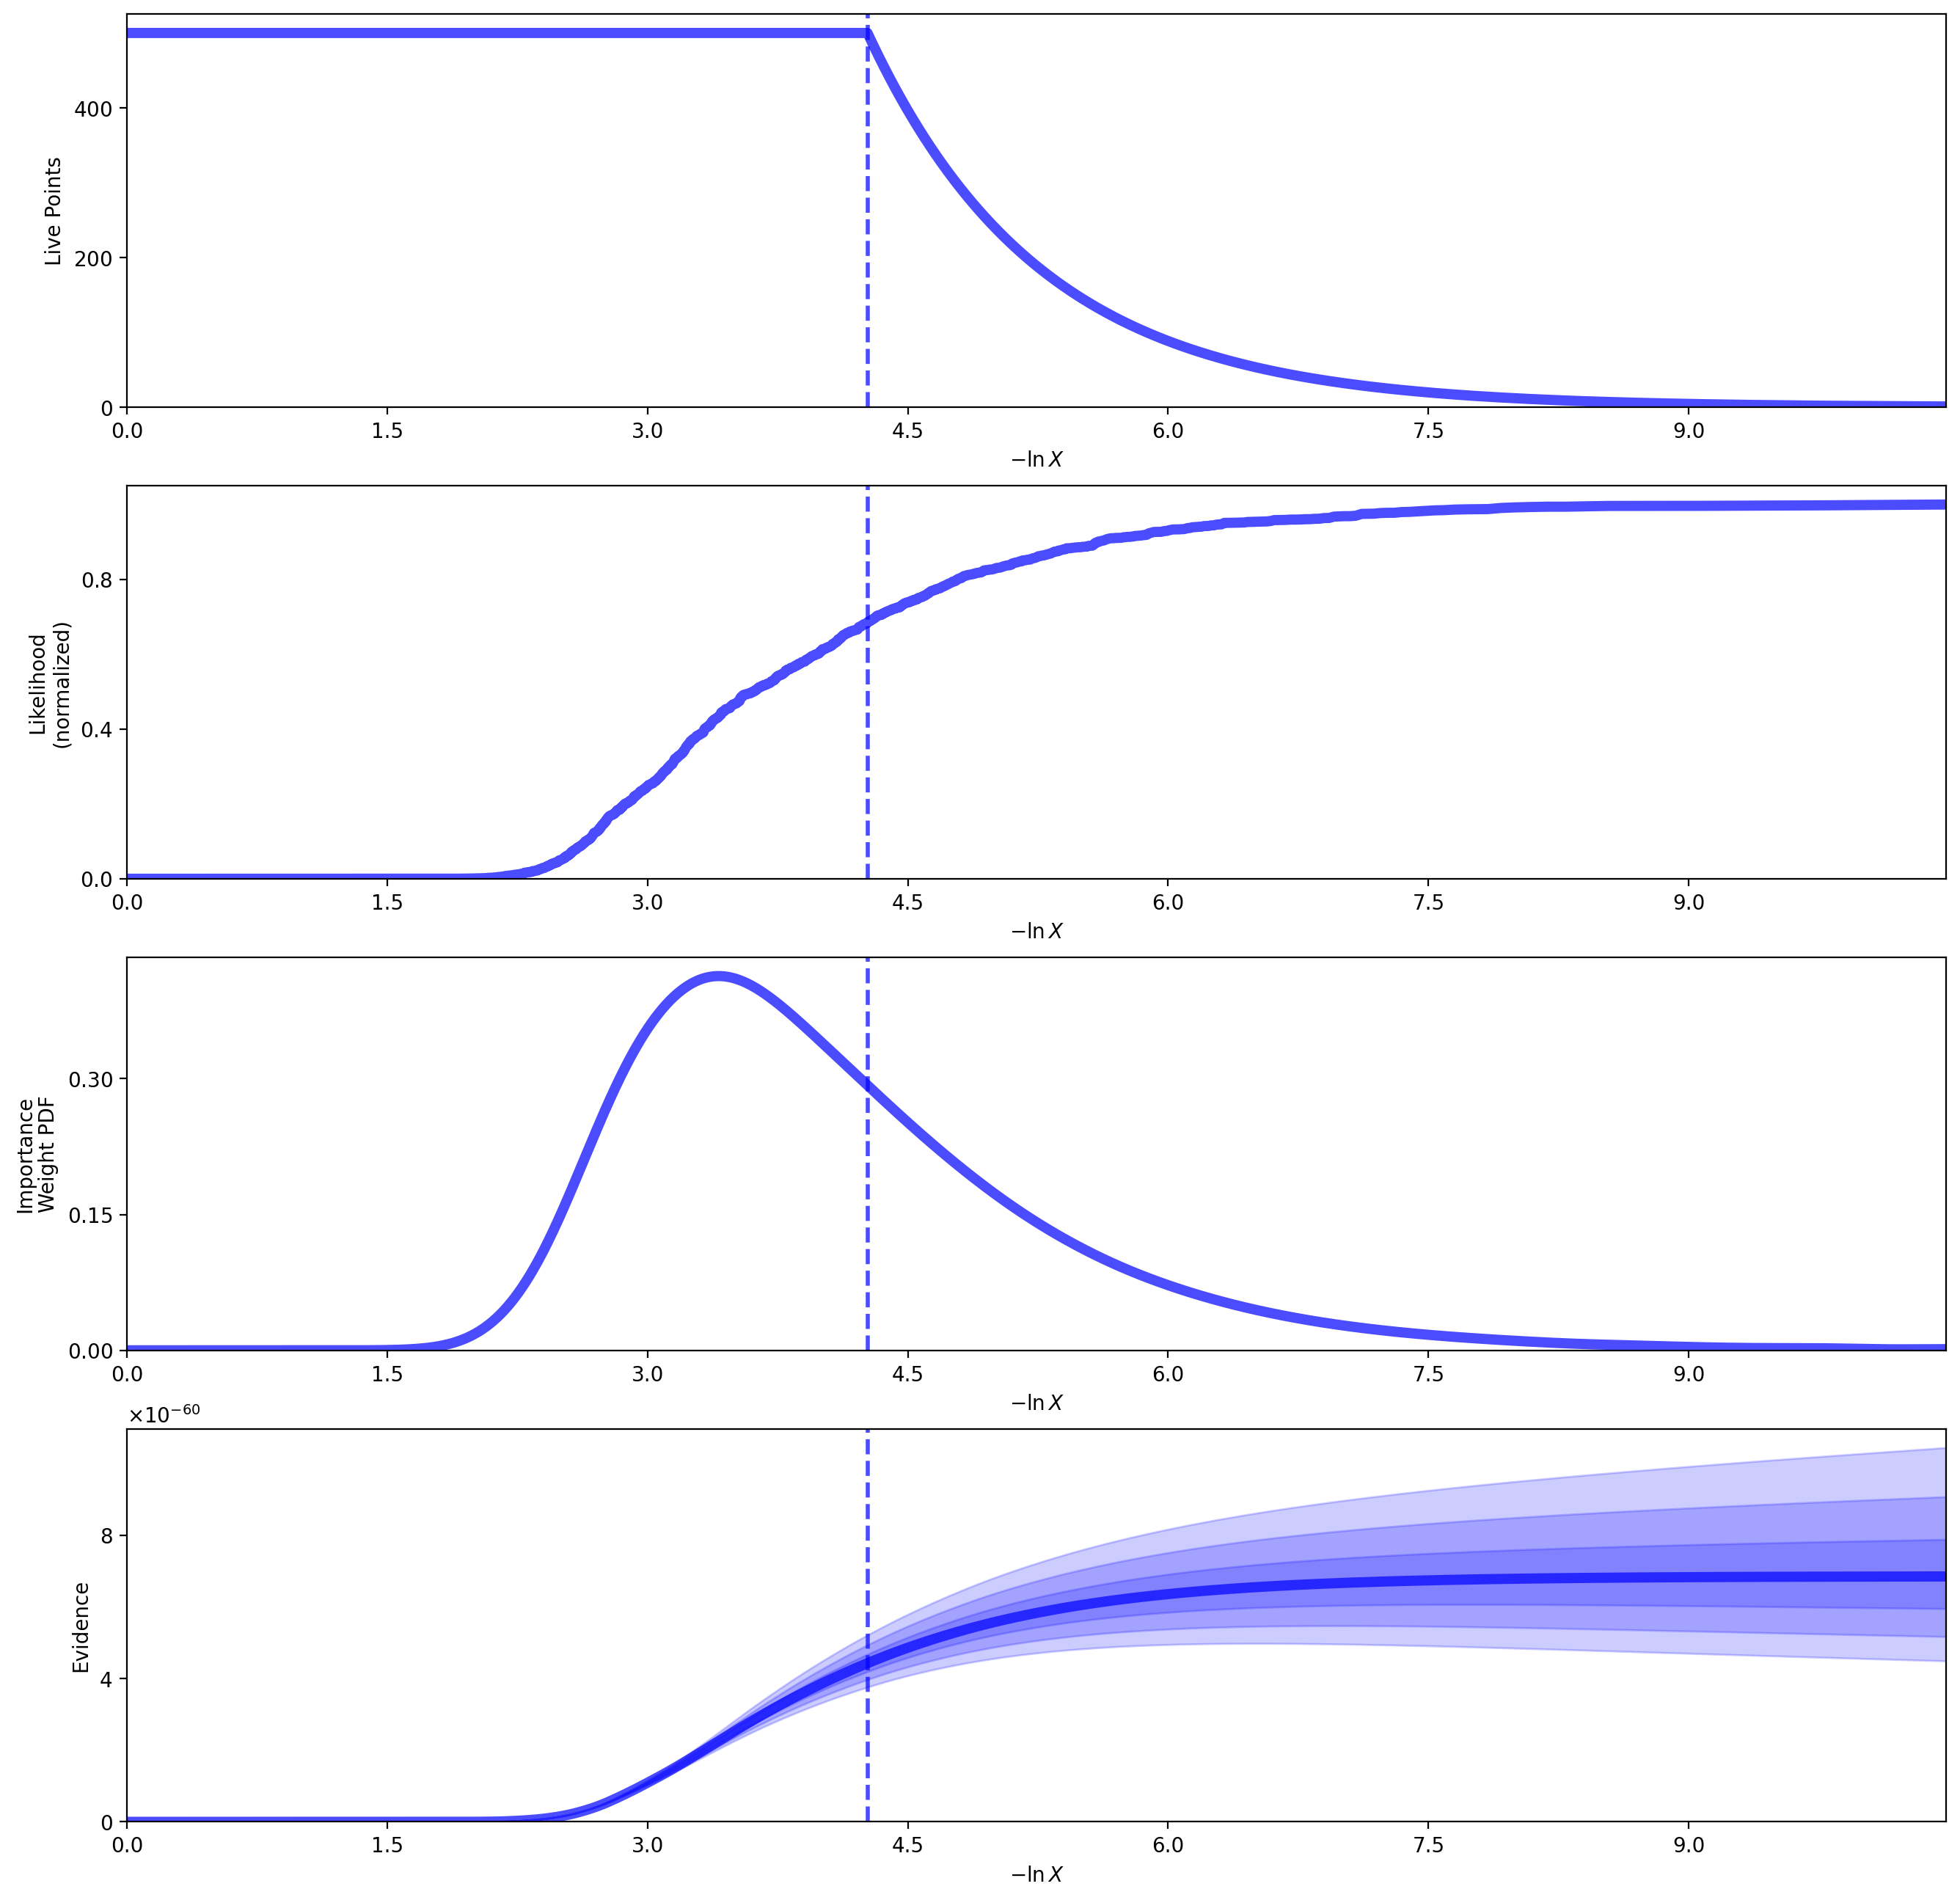

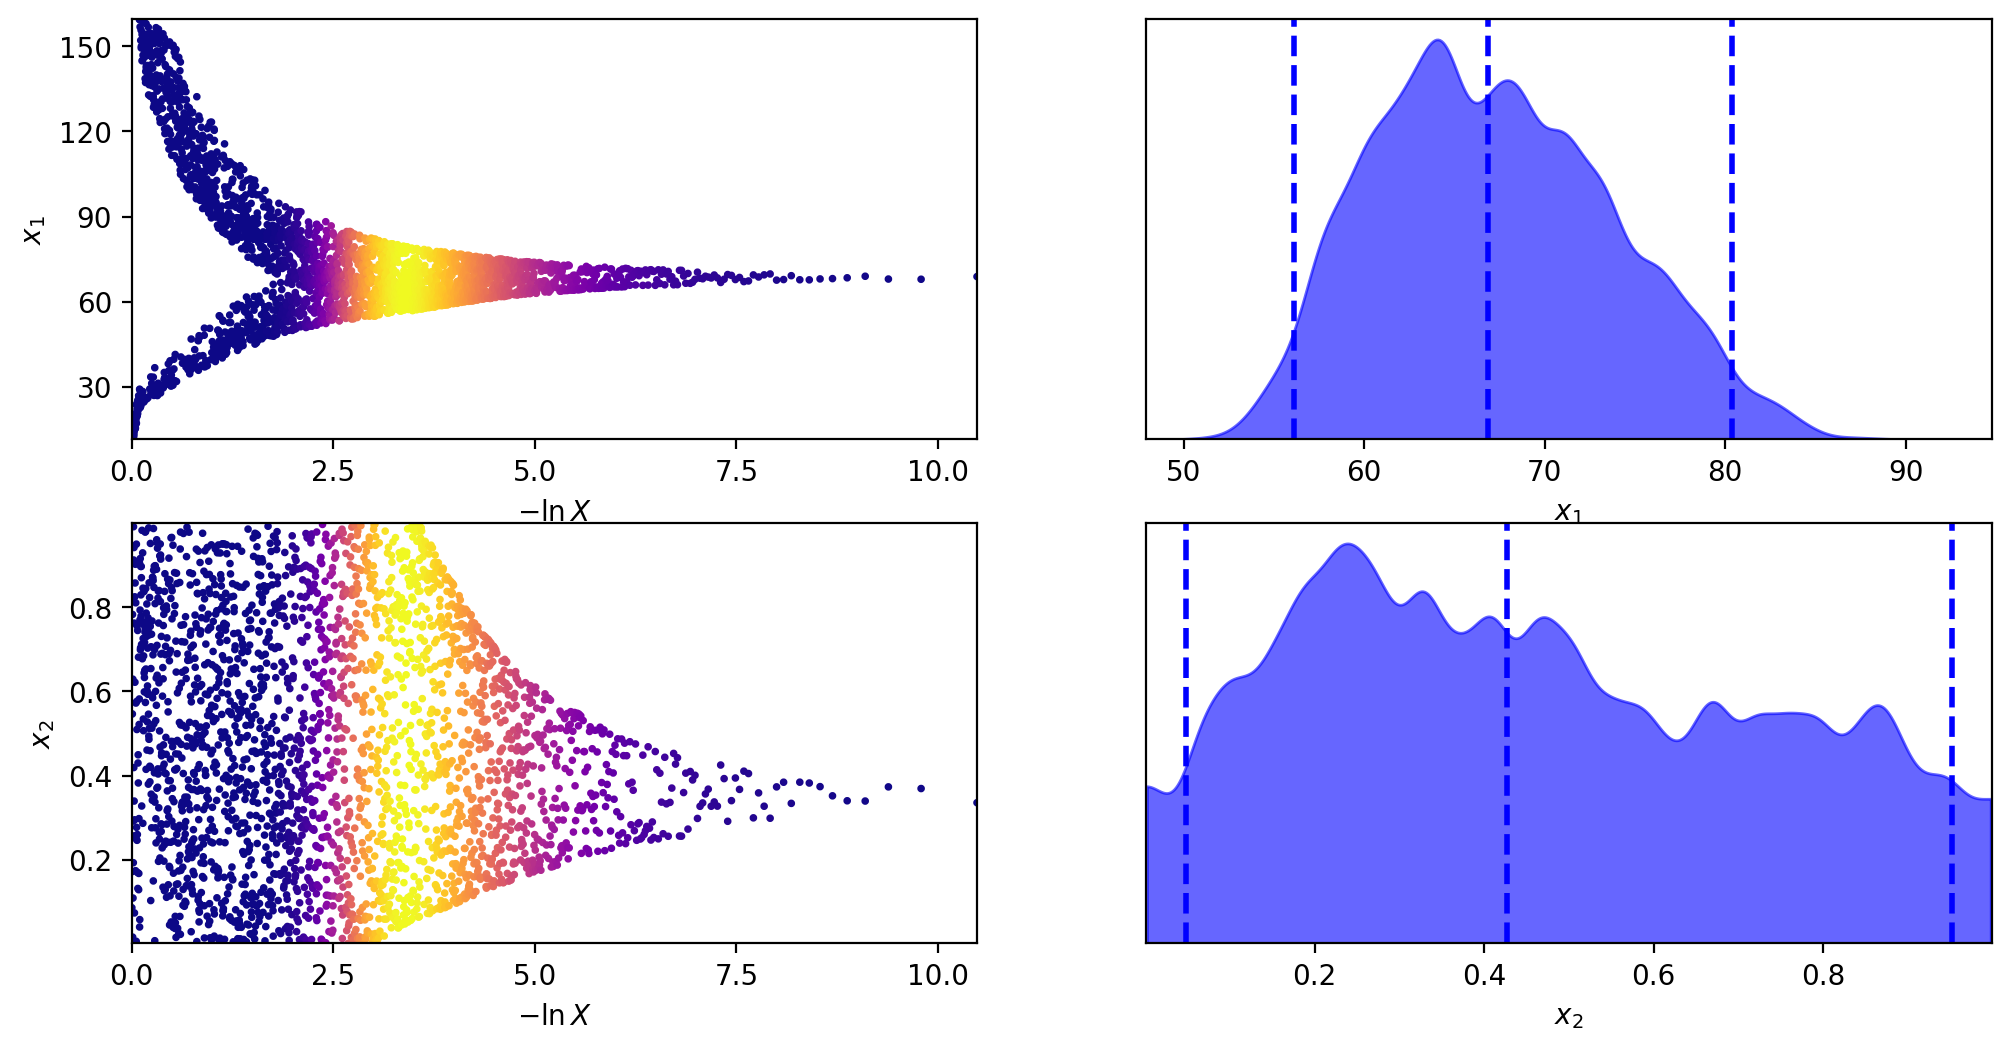

In [7]:
rfig, raxes = dyplot.runplot(sresults1)
tfig, taxes = dyplot.traceplot(sresults1)

samples1 = sresults1.samples
weights1 = np.exp(sresults1.logwt - sresults1.logz[-1])
evidence1 = sresults1.logz[-1]

best_param1 = np.array([dyfunc.quantile(samps, 0.5, weights=weights1)
             for samps in samples1.T]).flatten()
quantiles1 = np.array([dyfunc.quantile(samps, [0.05, 0.95], weights=weights1)
             for samps in samples1.T])
print('Median and 90% credible region:')
for i, l in zip(range(ndim),['H0','Omega_m']):
    X=best_param1[i].item()
    p5, p95 = quantiles1[i]
    print(l+':  ', round(X,3), '  +', round(p95.item()-X,3), '  -', round(X-p5.item(),3))
    

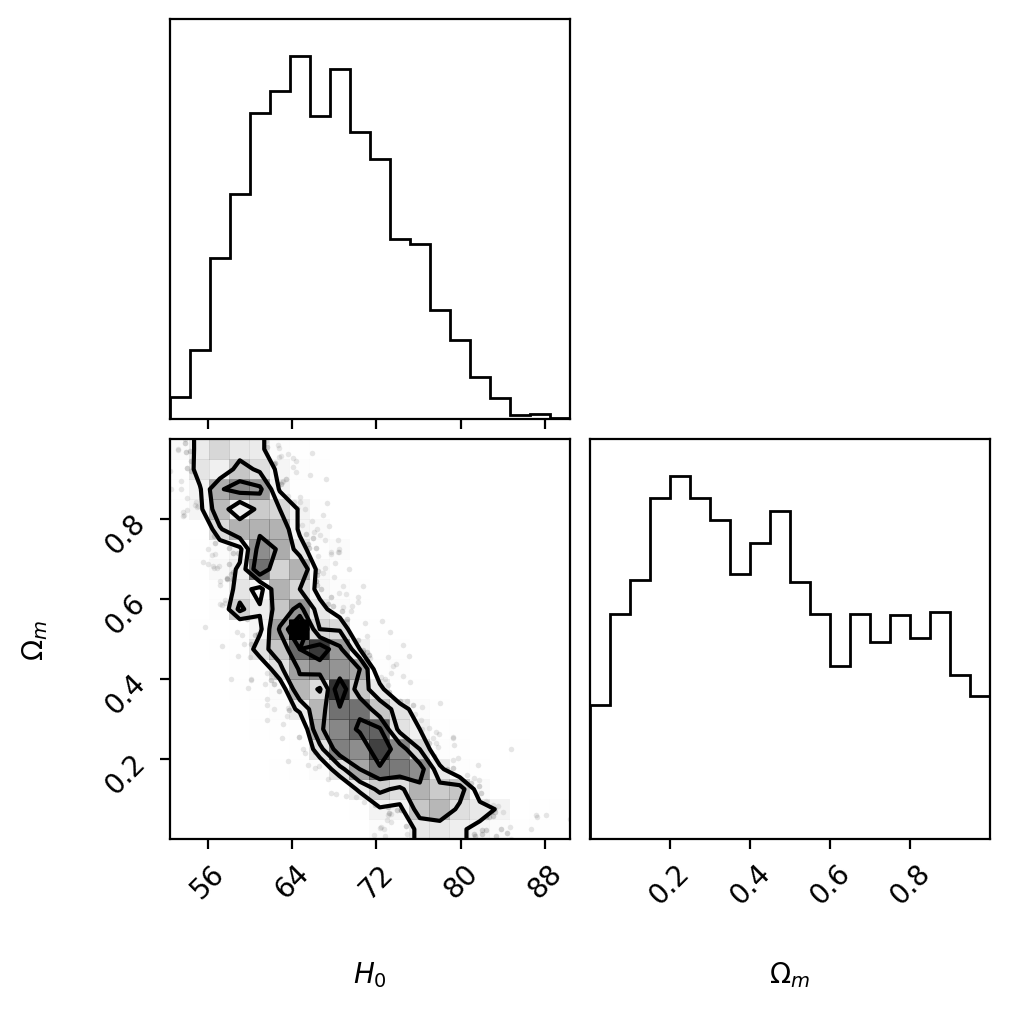

In [8]:
samples_equal1 = dyfunc.resample_equal(samples1, weights1)
corner.corner(samples_equal1, labels=['$H_{0}$', '$\Omega_{m}$']);

$H_0$ and $\Omega_m$ are clearly correlated

### Without dark energy

In [9]:
ndim=1
sampler2 = dynesty.NestedSampler(logLikelihood2, Prior_transform2, ndim, logl_args=[z_sample,mu_sample,dmu])
sampler2.run_nested()
sresults2 = sampler2.results

2010it [00:16, 119.31it/s, +500 | bound: 1 | nc: 1 | ncall: 18696 | eff(%): 13.794 | loglstar:   -inf < -133.530 <    inf | logz: -136.644 +/-  0.055 | dlogz:  0.001 >  0.509]


Median and 90% credible region:
H0:   57.688   + 4.116   - 4.003


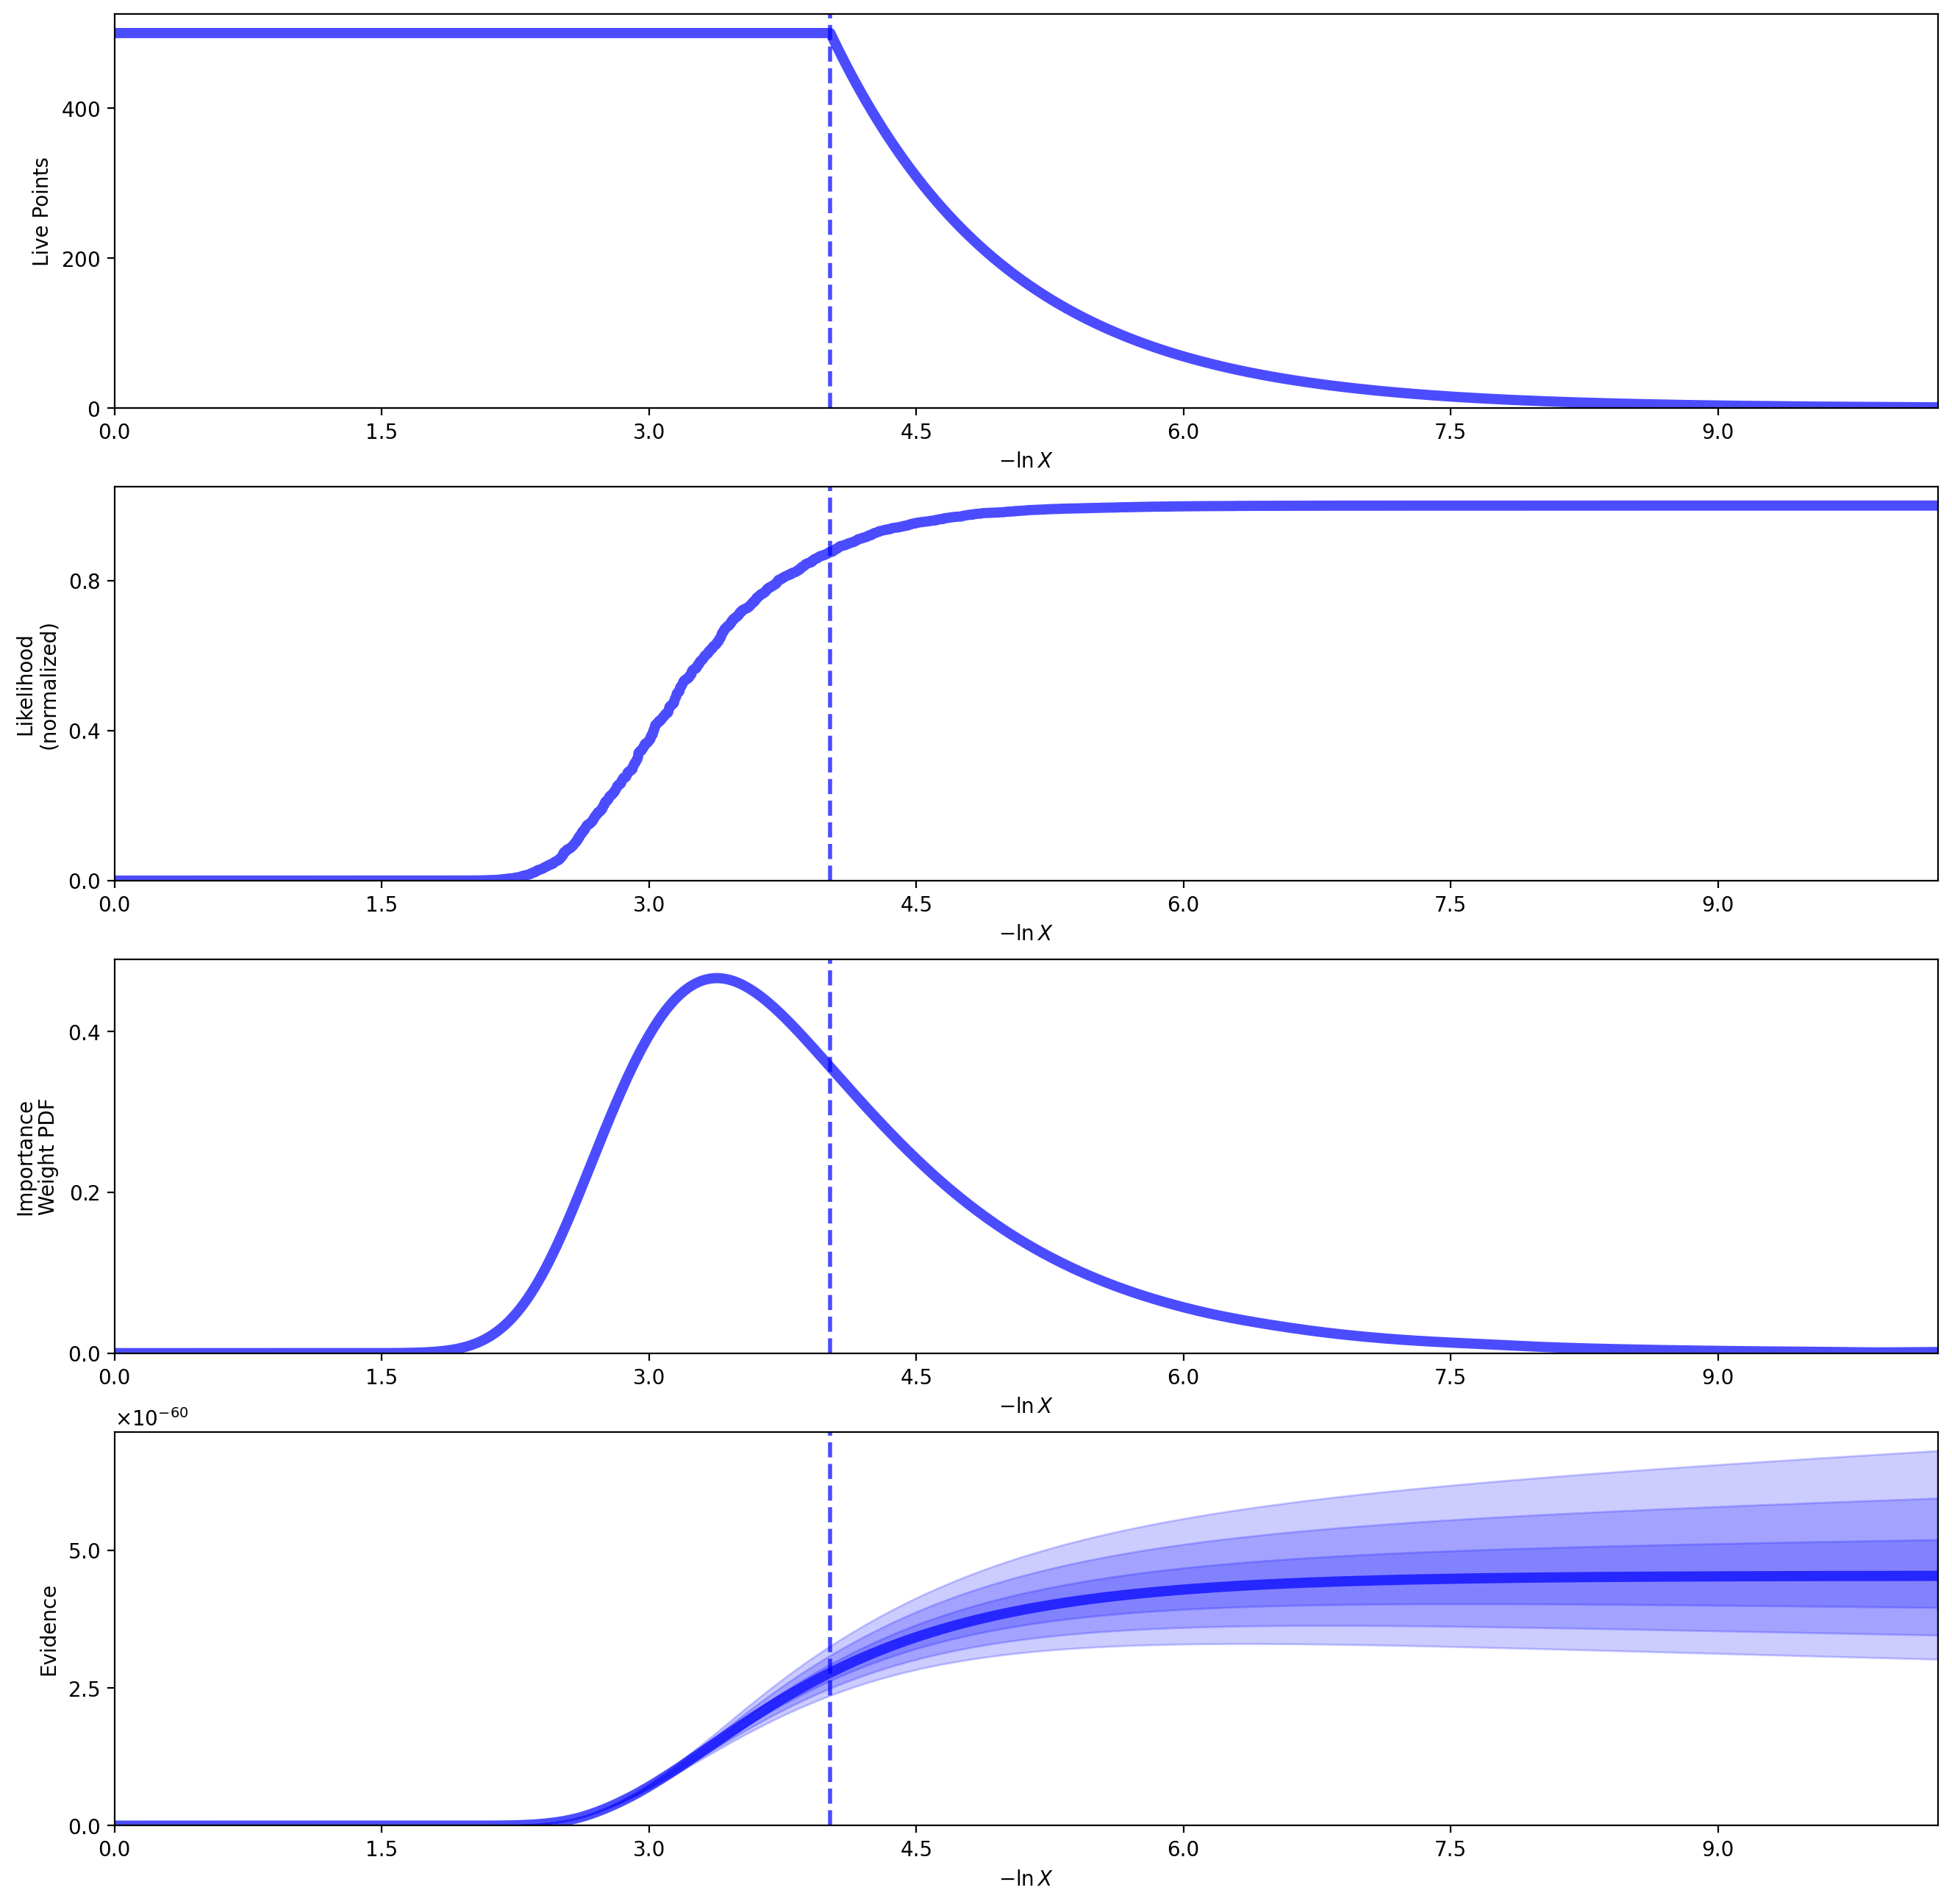

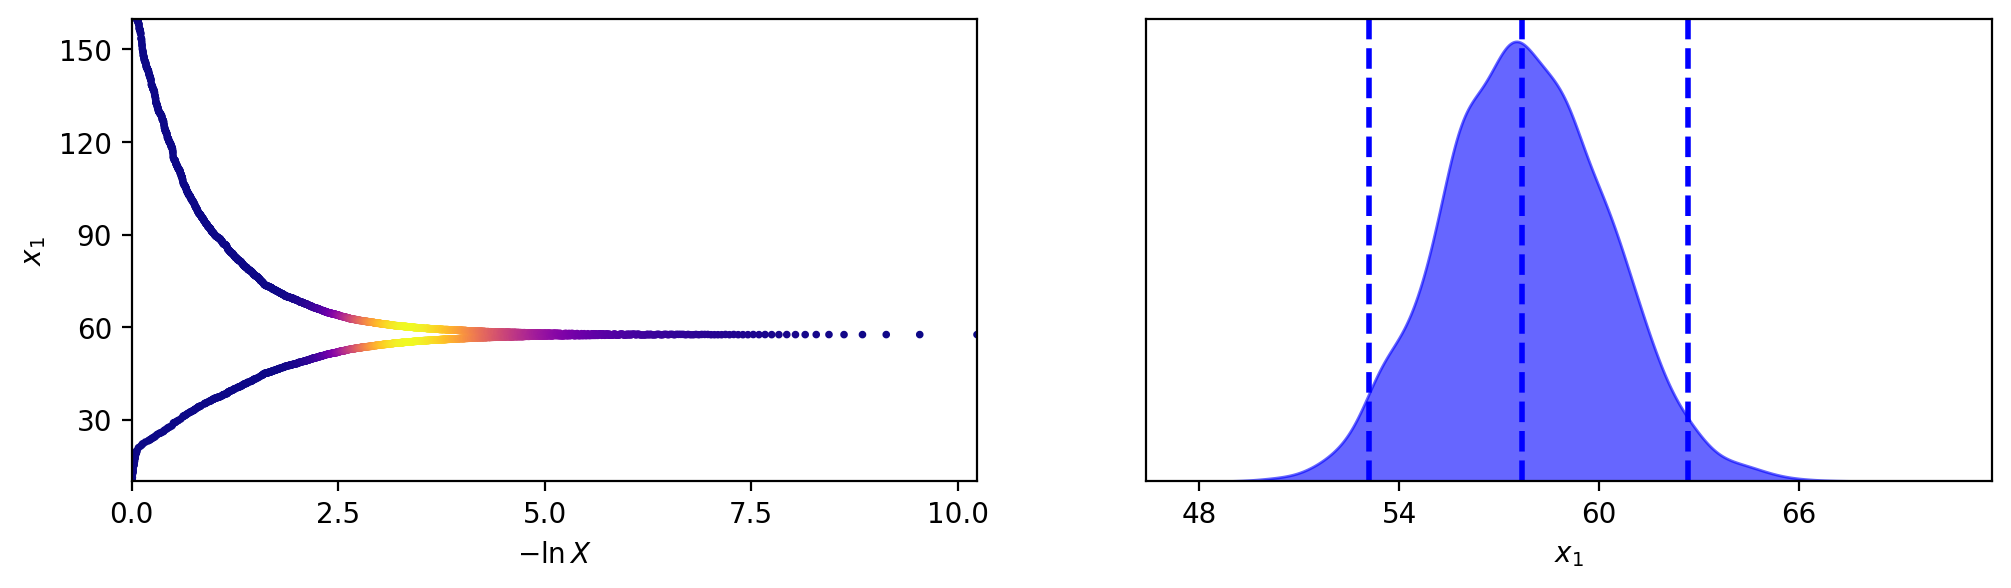

In [10]:
rfig, raxes = dyplot.runplot(sresults2)
tfig, taxes = dyplot.traceplot(sresults2)

samples2 = sresults2.samples
weights2 = np.exp(sresults2.logwt - sresults2.logz[-1])
evidence2 = sresults2.logz[-1]

best_param2 = np.array([dyfunc.quantile(samps, 0.5, weights=weights2)
             for samps in samples2.T]).flatten()
quantiles2 = np.array([dyfunc.quantile(samps, [0.05, 0.95], weights=weights2)
             for samps in samples2.T])
print('Median and 90% credible region:')
for i, l in zip(range(ndim),['H0']):
    X=best_param2[i].item()
    p5, p95 = quantiles2[i]
    print(l+':  ', round(X,3), '  +', round(p95.item()-X,3), '  -', round(X-p5.item(),3))

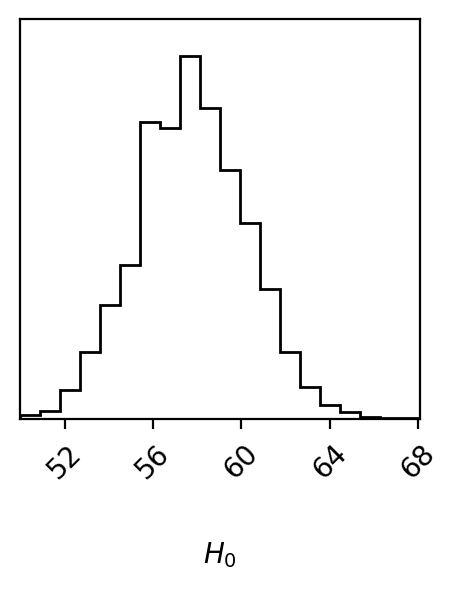

In [11]:
samples_equal2 = dyfunc.resample_equal(samples2, weights2)
corner.corner(samples_equal2, labels=['$H_0$']);

## Compare the two models

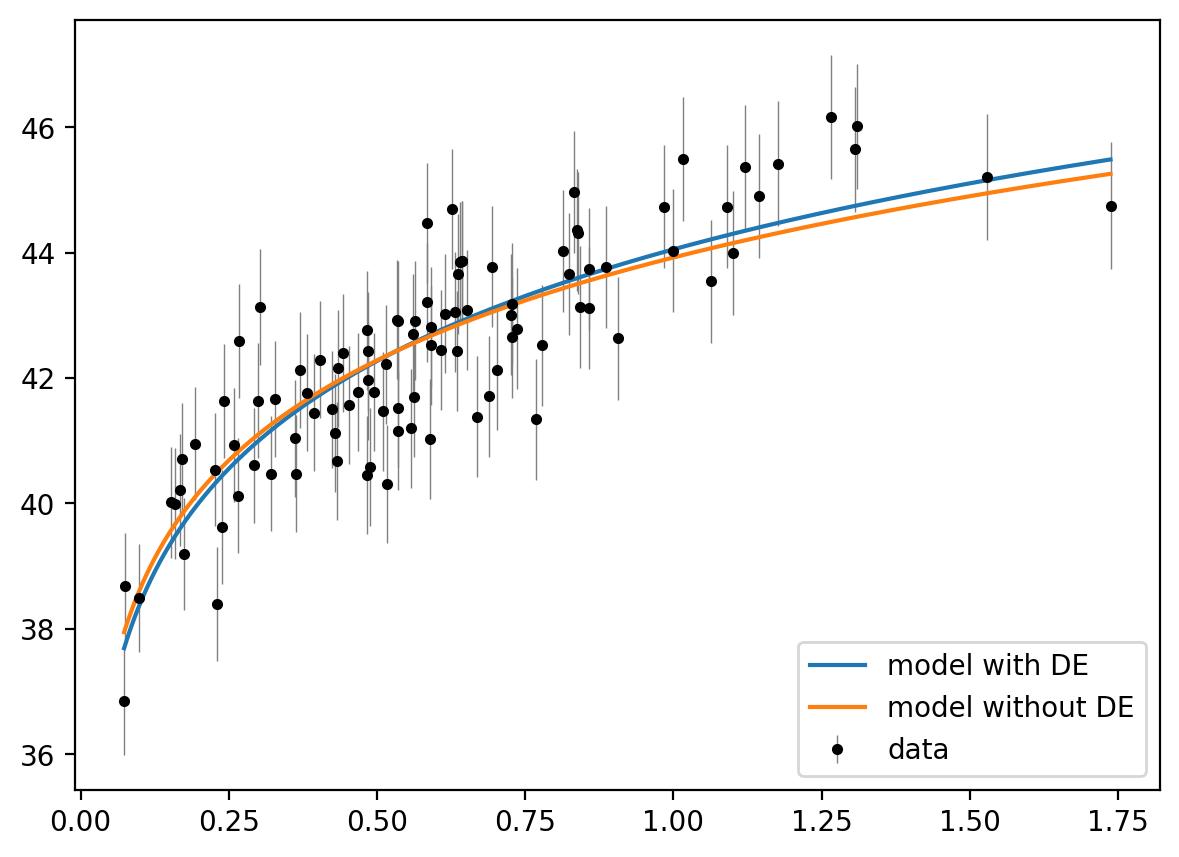

In [12]:
x_grid = np.linspace(min(x[:,0]),max(x[:,0]),1000)[:, np.newaxis]
y_pred1 = model_de(x_grid, best_param1)
y_pred2 = model_no_de(x_grid, best_param2)

plt.errorbar(z_sample, mu_sample, dmu, fmt='.k', ecolor='gray', lw=0.5,label='data')
plt.plot(x_grid, y_pred1, '-', color='C0', label='model with DE')
plt.plot(x_grid, y_pred2, '-', color='C1', label='model without DE')

plt.legend(loc="lower right",fontsize=10)
plt.show()

In [13]:
print('Ratio between Evidence1 and Evidence2 = ', np.exp(evidence1)/np.exp(evidence2))

Ratio between Evidence1 and Evidence2 =  1.511029480724994


## Generate new data

In [14]:
N=500
z_new = scipy.stats.uniform(0,2).rvs(N)

In [15]:
mu_GP, dmu_GP = gp.predict(z_new[:,np.newaxis], return_std=True)
mu_GP = np.random.normal(mu_GP, dmu_GP)

H0_Om = samples_equal1[np.random.randint(len(z_new))]

mu_model = model_de(z_new, H0_Om)

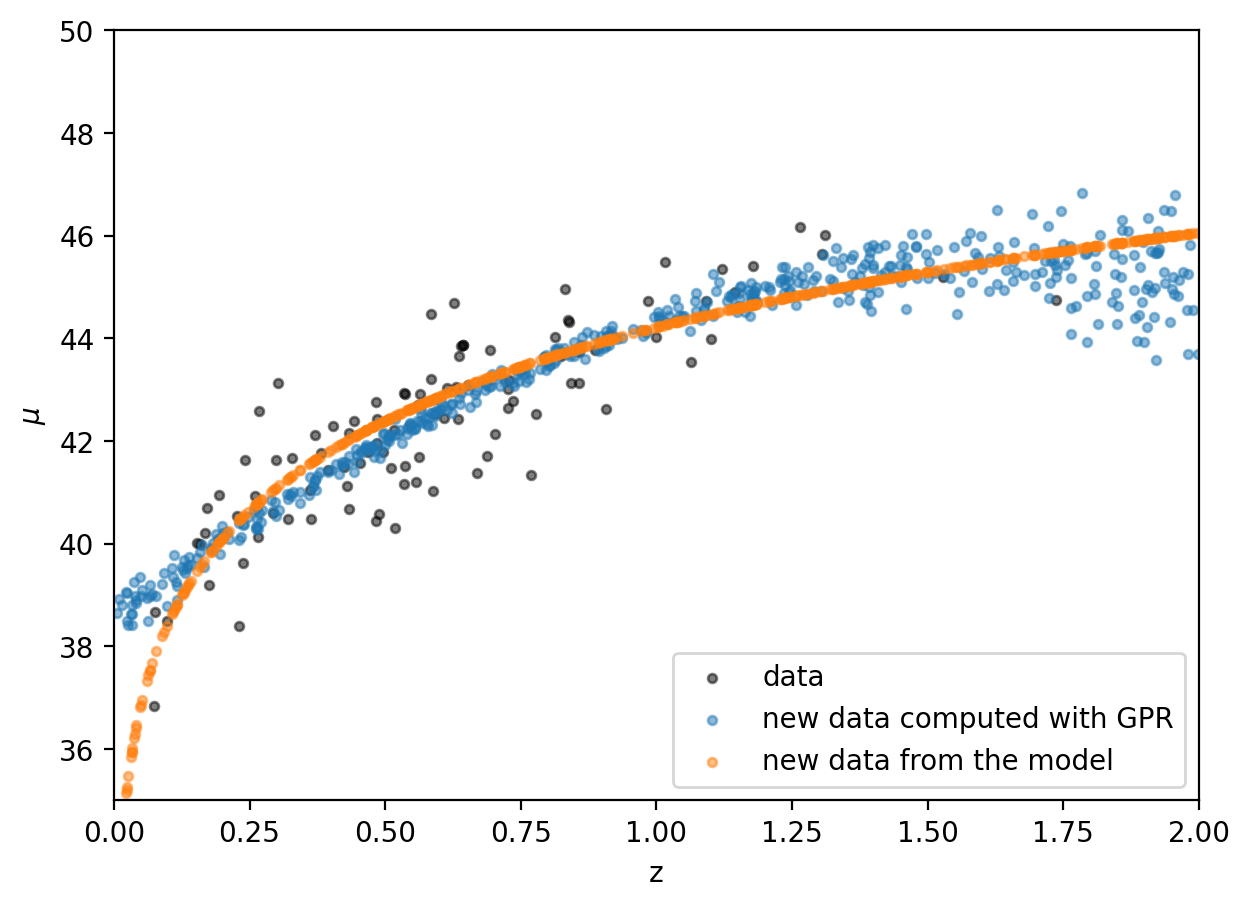

In [16]:
plt.scatter(z_sample, mu_sample, s=10, color = 'k', alpha=0.5, label='data')
plt.scatter(z_new, mu_GP, s=10, color = 'C0', alpha=0.5, label='new data computed with GPR')
plt.scatter(z_new, mu_model, s=10, color = 'C1', alpha =0.5, label='new data from the model')

plt.xlabel("z")
plt.ylabel("$\mu$")
plt.legend(loc='lower right')
plt.xlim(0,2)
plt.ylim(35,50)
plt.show()